In [1]:
%matplotlib inline

import os
import random

import matplotlib.pyplot as plt
import numpy as np

import pathlib
from tqdm import tqdm

import skimage.io
import skimage.segmentation

import sys
__file__ = '012-prerpocessing.ipynb'
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))

import utils.dirtools  # utils need to a package with __init__.py in it
import utils.augmentation

from config import config_vars

### Setting Directory and Global Vars

In [2]:
config_vars["root_directory"] = '../CELL/seg_samples_KZ_images/'

experiment_name = '00'

config_vars = utils.dirtools.setup_working_directories(config_vars)
config_vars = utils.dirtools.setup_experiment(config_vars, experiment_name)

In [3]:
config_vars

{'root_directory': '../CELL/seg_samples_KZ_images/',
 'max_training_images': 0,
 'create_split_files': False,
 'training_fraction': 0.5,
 'validation_fraction': 0.25,
 'transform_images_to_PNG': True,
 'pixel_depth': 8,
 'min_nucleus_size': 25,
 'boundary_size': 2,
 'augment_images': False,
 'elastic_points': 16,
 'elastic_distortion': 5,
 'elastic_augmentations': 10,
 'learning_rate': 0.0001,
 'epochs': 15,
 'steps_per_epoch': 500,
 'batch_size': 10,
 'val_batch_size': 10,
 'rescale_labels': True,
 'crop_size': 256,
 'cell_min_size': 16,
 'boundary_boost_factor': 1,
 'object_dilation': 3,
 'raw_images_dir': '../CELL/seg_samples_KZ_images/raw_images/',
 'raw_annotations_dir': '../CELL/seg_samples_KZ_images/raw_annotations/',
 'path_files_training': '../CELL/seg_samples_KZ_images/training.txt',
 'path_files_validation': '../CELL/seg_samples_KZ_images/validation.txt',
 'path_files_test': '../CELL/seg_samples_KZ_images/test.txt',
 'normalized_images_dir': '../CELL/seg_samples_KZ_images/no

### Normalize Raw Images to [0,1]
dtype: uint8 

In [4]:
# Create output directories for transformed data

os.makedirs(config_vars["normalized_images_dir"], exist_ok=True)
os.makedirs(config_vars["boundary_labels_dir"], exist_ok=True)

##### Depict the Raw Images

0074.tif


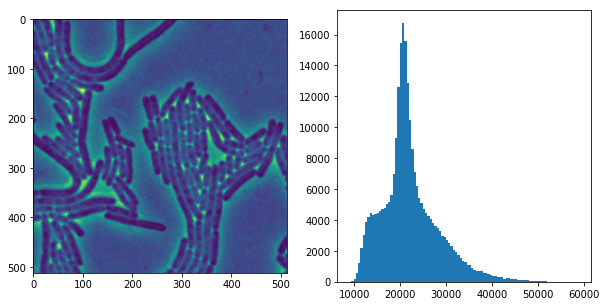

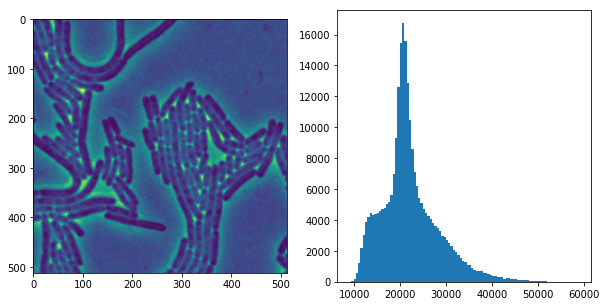

In [7]:
filename = os.listdir(config_vars["raw_images_dir"])
filename = sorted(filename)
print(filename[-1])
img = skimage.io.imread(config_vars["raw_images_dir"] + filename[-1])

figure, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(img)
ax[1].hist(img.flatten(), bins=100)
figure
# plt.figure(figsize=(5, 5))
# plt.imshow(img)
# plt.show()
# plt.hist(img.flatten(), bins=100)
# plt.show()

In [19]:
if config_vars["transform_images_to_PNG"]:
    filelist = sorted(os.listdir(config_vars["raw_images_dir"]))
    # run over all raw images
    for filename in tqdm(filelist):
        # load image and its annotation
        orig_img = skimage.io.imread(config_vars["raw_images_dir"] + filename)       
        # normalize to [0,1]
        percentile = 99.9
        high = np.percentile(orig_img, percentile)  # maximum for all image
        low = np.percentile(orig_img, 100-percentile)

        img = np.minimum(high, orig_img)
        img = np.maximum(low, img)

        # gives float64, thus cast to 8 bit later
        img = (img - low) / (high - low) 
        img = skimage.img_as_ubyte(img) 

        skimage.io.imsave(config_vars["normalized_images_dir"] + filename[:-3] + 'png', img)    
else:
    config_vars["normalized_images_dir"] = config_vars["raw_images_dir"]

  0%|          | 0/75 [00:00<?, ?it/s]/home/lanbowen23/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
100%|██████████| 75/75 [00:03<00:00, 23.69it/s]


In [20]:
print(img.dtype, img.shape)

uint8 (512, 512)


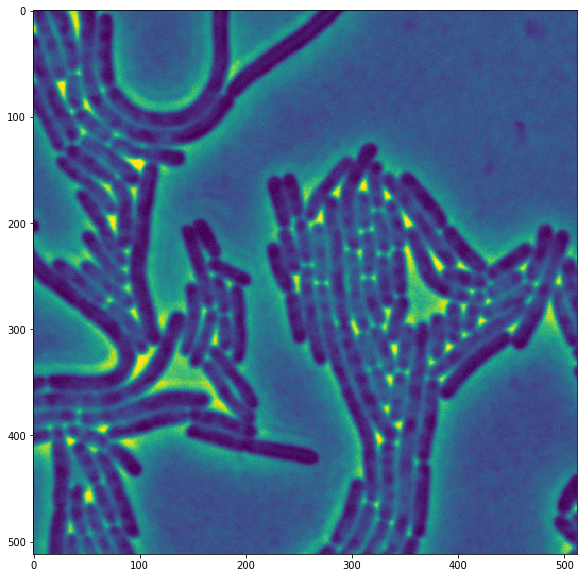

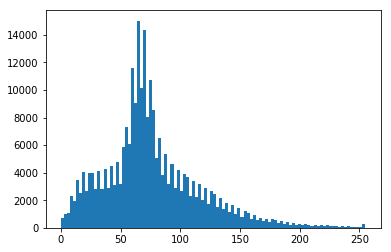

In [21]:
filenames = sorted(os.listdir(config_vars["normalized_images_dir"]))
img = skimage.io.imread(config_vars["normalized_images_dir"] + filenames[-1])

plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.show()
plt.hist(img.flatten(), bins=100)
plt.show()

### Transform Seg Annot to Boundary Annot
1. use `skimage.segmentation.find_boundaries` to find boundary of each nucleus  
2. save annotation/label/mask into a new 3 channel buffer: 0 is bg; 1 is cell; 2 is boundary

In [ ]:
filelist = sorted(os.listdir(config_vars["raw_annotations_dir"]))
annot = skimage.io.imread(config_vars["raw_annotations_dir"] + filelist[1])
annot.shape

In [ ]:
filelist = sorted(os.listdir(config_vars["raw_annotations_dir"]))
total_objects = 0

# run over all raw images
for filename in tqdm(filelist):
    # GET ANNOTATION
    annot = skimage.io.imread(config_vars["raw_annotations_dir"] + filename)
    
    # label the annotations nicely to prepare for future filtering operation
    annot = skimage.morphology.label(annot)
    total_objects += len(np.unique(annot)) - 1
    
    # filter small objects, e.g. micronulcei
    annot = skimage.morphology.remove_small_objects(annot, min_size=config_vars["min_nucleus_size"])
    # find boundaries
    boundaries = skimage.segmentation.find_boundaries(annot)
    # make the boundary wider
    for k in range(2, config_vars["boundary_size"], 2):
        boundaries = skimage.morphology.binary_dilation(boundaries)
        
    # 3-CHANNEL BINARY LABEL
    # prepare buffer for binary label
    label_binary = np.zeros((annot.shape + (3,)))  # cannot use dtype=np.uint8 here
    # write binary label
    label_binary[(annot == 0) & (boundaries == 0), 0] = 1  # bg
    label_binary[(annot != 0) & (boundaries == 0), 1] = 1  # cell
    label_binary[boundaries == 1, 2] = 1  # boundary
    # Convert an image to unsigned byte format, with values in [0, 255]
    label_binary = skimage.img_as_ubyte(label_binary)
    # save it - converts image to range from 0 to 255
    skimage.io.imsave(config_vars["boundary_labels_dir"] + filename, label_binary)
    
print("Total objects: ",total_objects)

In [ ]:
# Show example image 
print(annot.dtype, annot.shape)

# plot original annotation
plt.figure(figsize=(10,10))
plt.imshow(annot, cmap="nipy_spectral")
plt.show()

# plot boundary labels
plt.figure(figsize=(10,10))
plt.imshow(label_binary)
plt.show()